# Import Libraries and Dataset

## Import Libraries

In [1]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD
from collections import defaultdict
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer, util

c:\Users\angge\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Dataset

In [2]:
book_df = pd.read_csv('dataset\Books.csv')
ratings_df = pd.read_csv('dataset\Ratings.csv')
users_df = pd.read_csv(r'dataset\Users.csv')

C:\Users\angge\AppData\Local\Temp\ipykernel_2340\1692912463.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book_df = pd.read_csv('dataset\Books.csv')


# Data Understanding

## Pengecekan Kondisi Data

In [3]:
# Pengecekan Missing Values
print("=== Missing Values Book Data ===")
print(book_df.isnull().sum())

# Pengecekan Duplikat
print("\n=== Duplikat Book Data ===")
print("Jumlah duplikat ISBN:", book_df.duplicated(subset=['ISBN']).sum())
print("Jumlah duplikat seluruh baris:", book_df.duplicated().sum())

# Pengecekan Outlier
print("\n=== Outlier Book Data ===")

# Konversi Year-Of-Publication ke numerik (handle errors dengan coerce)
book_df['Year-Of-Publication'] = pd.to_numeric(book_df['Year-Of-Publication'], errors='coerce')

# Identifikasi nilai yang tidak valid
print("\nNilai tidak valid dalam Year-Of-Publication:")
invalid_years = book_df[book_df['Year-Of-Publication'].isna()]
print("Jumlah nilai NaN:", len(invalid_years))
print("Contoh baris dengan tahun tidak valid:")
print(invalid_years.head())

# Identifikasi tahun ekstrim
print("\nTahun di luar range normal (1900-2023):")
extreme_years = book_df[(book_df['Year-Of-Publication'] < 1900) | 
                (book_df['Year-Of-Publication'] > 2023)]
print(extreme_years['Year-Of-Publication'].value_counts().sort_index())

=== Missing Values Book Data ===
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

=== Duplikat Book Data ===
Jumlah duplikat ISBN: 0
Jumlah duplikat seluruh baris: 0

=== Outlier Book Data ===

Nilai tidak valid dalam Year-Of-Publication:
Jumlah nilai NaN: 3
Contoh baris dengan tahun tidak valid:
              ISBN                                         Book-Title  \
209538  078946697X  DK Readers: Creating the X-Men, How It All Beg...   
220731  2070426769  Peuple du ciel, suivi de 'Les Bergers\";Jean-M...   
221678  0789466953  DK Readers: Creating the X-Men, How Comic Book...   

       Book-Author  Year-Of-Publication  \
209538        2000                  NaN   
220731        2003                  NaN   
221678        2000                  NaN   

                                                Publisher  \
209538  ht

In [4]:
# Pengecekan Missing Values
print("=== Missing Values Ratings Data ===")
print(ratings_df.isnull().sum())

# Pengecekan Duplikat
print("\n=== Duplikat Ratings Data ===")
print("Jumlah duplikat (User-ID + ISBN):", 
      ratings_df.duplicated(subset=['User-ID', 'ISBN']).sum())
print("Jumlah duplikat seluruh baris:", ratings_df.duplicated().sum())

# Pengecekan Outlier
print("\n=== Outlier Ratings Data ===")
print("\nDistribusi Rating:")
print(ratings_df['Book-Rating'].value_counts().sort_index())

=== Missing Values Ratings Data ===
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

=== Duplikat Ratings Data ===
Jumlah duplikat (User-ID + ISBN): 0
Jumlah duplikat seluruh baris: 0

=== Outlier Ratings Data ===

Distribusi Rating:
Book-Rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64


In [5]:
# Pengecekan Missing Values
print("=== Missing Values Users Data ===")
print(users_df.isnull().sum())

# Pengecekan Duplikat
print("\n=== Duplikat Users Data ===")
print("Jumlah duplikat User-ID:", users_df.duplicated(subset=['User-ID']).sum())
print("Jumlah duplikat seluruh baris:", users_df.duplicated().sum())

# Pengecekan Outlier
print("\n=== Outlier Users Data ===")
print("\nNilai unik Usia:")
print(sorted(users_df['Age'].unique()))

# Pengecekan nilai ekstrim usia
print("\nUsia di luar range normal (5-100 tahun):")
print(users_df[(users_df['Age'] < 5) | (users_df['Age'] > 100)]['Age'].value_counts())

=== Missing Values Users Data ===
User-ID          0
Location         0
Age         110762
dtype: int64

=== Duplikat Users Data ===
Jumlah duplikat User-ID: 0
Jumlah duplikat seluruh baris: 0

=== Outlier Users Data ===

Nilai unik Usia:
[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.

## Distribusi Rating
Distribusi rating digunakan untuk melihat bagaimana penyebaran nilai rating yang diberikan oleh pengguna terhadap buku.

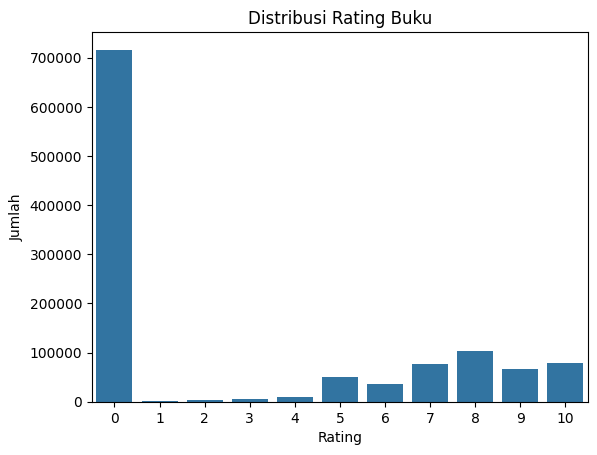

In [6]:
sns.countplot(data=ratings_df, x='Book-Rating')
plt.title('Distribusi Rating Buku')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

## Buku Paling Banyak Disukai
Visualisasi ini bertujuan untuk mengetahui buku-buku apa saja yang paling sering mendapatkan rating dari pengguna, sebagai langkah awal identifikasi popularitas buku.

In [7]:
top_books = ratings_df['ISBN'].value_counts().head(10)
top_books = top_books.reset_index().merge(book_df, left_on='ISBN', right_on='ISBN')
top_books[['Book-Title', 'ISBN']]


,Book-Title,ISBN
0,Wild Animus,0971880107
1,The Lovely Bones: A Novel,0316666343
2,The Da Vinci Code,0385504209
3,Divine Secrets of the Ya-Ya Sisterhood: A Novel,0060928336
4,The Red Tent (Bestselling Backlist),0312195516
5,A Painted House,044023722X
6,The Secret Life of Bees,0142001740
7,Snow Falling on Cedars,067976402X
8,Angels &amp; Demons,0671027360


# Data Preparation

## Menghapus Data Missing dan Outlier
Pada tahap ini, masing-masing dataset dilakukan penanganan terhadap data missing dan data outlier.

In [8]:
# === Books.csv ===

# Remove rows in 'book_df' that have missing values in the columns:
# 'Book-Author', 'Publisher', and 'Image-URL-L'
book_df = book_df.dropna(subset=['Book-Author', 'Publisher', 'Image-URL-L'])

# Filter out rows where 'Year-Of-Publication' is not within the valid range of 1900 to 2023
# This also removes NaN values in the 'Year-Of-Publication' column
book_df = book_df[book_df['Year-Of-Publication'].between(1900, 2023)]


# === Ratings.csv ===

# Remove rows in 'ratings_df' where 'Book-Rating' is 0,
# assuming these represent uninformative or invalid ratings
ratings_df = ratings_df[ratings_df['Book-Rating'] != 0]


# === Users.csv ===

# Remove rows in 'users_df' with missing values in the 'Age' column
users_df = users_df.dropna(subset=['Age'])

# Filter out users with age values outside the reasonable range of 5 to 100 years
users_df = users_df[users_df['Age'].between(5, 100)]


## Menggabungkan Datasets
Menggabungkan tiga DataFrame (ratings_df, users_df, dan book_df) menjadi satu DataFrame terintegrasi bernama dataset, yang hanya berisi kolom yang relevan untuk analisis sistem rekomendasi atau eksplorasi data buku.

In [9]:
# Merge the datasets
user_rating_df = ratings_df.merge(users_df, left_on='User-ID', right_on='User-ID')
dataset = book_df.merge(user_rating_df, left_on='ISBN', right_on='ISBN')
dataset = dataset[['ISBN', 'Book-Title', 'Book-Author', 'User-ID', 'Book-Rating']]
dataset.reset_index(drop=True, inplace=True)
dataset.head()


,ISBN,Book-Title,Book-Author,User-ID,Book-Rating
0,0002005018,Clara Callan,Richard Bruce Wright,67544,8
1,0002005018,Clara Callan,Richard Bruce Wright,219008,7
2,0002005018,Clara Callan,Richard Bruce Wright,263325,6
3,0060973129,Decision in Normandy,Carlo D'Este,2954,8
4,0060973129,Decision in Normandy,Carlo D'Este,152827,7


## Encoding dan Ekstraksi Fitur Konten
Melakukan transformasi pada data agar siap digunakan dalam model machine learning, terutama untuk sistem rekomendasi berbasis konten atau kolaboratif.

In [10]:
# Encode ISBN and User-ID
isbn_encoder = LabelEncoder()
user_encoder = LabelEncoder()
dataset['ISBN_encoded'] = isbn_encoder.fit_transform(dataset['ISBN'])
dataset['User_encoded'] = user_encoder.fit_transform(dataset['User-ID'])

# Merge dataset features
dataset['content'] = dataset['Book-Title'] + ' ' + dataset['Book-Author']
dataset.head()

,ISBN,Book-Title,Book-Author,User-ID,Book-Rating,ISBN_encoded,User_encoded,content
0,0002005018,Clara Callan,Richard Bruce Wright,67544,8,26,9573,Clara Callan Richard Bruce Wright
1,0002005018,Clara Callan,Richard Bruce Wright,219008,7,26,31008,Clara Callan Richard Bruce Wright
2,0002005018,Clara Callan,Richard Bruce Wright,263325,6,26,37425,Clara Callan Richard Bruce Wright
3,0060973129,Decision in Normandy,Carlo D'Este,2954,8,3690,407,Decision in Normandy Carlo D'Este
4,0060973129,Decision in Normandy,Carlo D'Este,152827,7,3690,21756,Decision in Normandy Carlo D'Este


In [11]:
# Get data information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263902 entries, 0 to 263901
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ISBN          263902 non-null  object
 1   Book-Title    263902 non-null  object
 2   Book-Author   263902 non-null  object
 3   User-ID       263902 non-null  int64 
 4   Book-Rating   263902 non-null  int64 
 5   ISBN_encoded  263902 non-null  int32 
 6   User_encoded  263902 non-null  int64 
 7   content       263902 non-null  object
dtypes: int32(1), int64(3), object(4)
memory usage: 15.1+ MB


# Content-Based Filtering (CBF)


## Penanganan Nilai Kosong & Pembuatan Fitur Gabungan Teks
Menangani nilai kosong yang dapat mengganggu proses pemodelan berbasis teks, serta membuat fitur gabungan yang berisi informasi deskriptif dari buku untuk digunakan dalam teknik representasi teks


In [12]:
# Handling nan value
dataset['Book-Author'] = dataset['Book-Author'].fillna('')
dataset['content'] = dataset['content'].fillna('')

# Merger the content
combined_features = dataset['Book-Title'] + ' ' + dataset['Book-Author'] + ' ' + dataset['content']
combined_features.drop_duplicates().reset_index(drop=True, inplace=True)
combined_features.head()

0    Clara Callan Richard Bruce Wright Clara Callan...
1    Clara Callan Richard Bruce Wright Clara Callan...
2    Clara Callan Richard Bruce Wright Clara Callan...
3    Decision in Normandy Carlo D'Este Decision in ...
4    Decision in Normandy Carlo D'Este Decision in ...
dtype: object

## Embedding Teks Menggunakan Pre-trained BERT
Mengubah fitur gabungan teks dari buku menjadi representasi vektor menggunakan model Sentence-BERT agar dapat digunakan dalam sistem rekomendasi berbasis kemiripan semantik antar buku.

In [13]:
# Use pre-trained model for text embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(combined_features.tolist(), convert_to_tensor=True)

## Fungsi: CBS_recommendation
Memberikan rekomendasi buku yang mirip secara semantik (berdasarkan isi dan penulis) dengan menggunakan representasi teks dari model BERT (SentenceTransformer).

In [14]:
def CBS_recommendation(title, top_n=5):
    if title not in dataset['Book-Title'].values:
        return f"Buku '{title}' tidak ditemukan."

    idx = dataset[dataset['Book-Title'] == title].index[0]
    query_embedding = embeddings[idx]

    cos_scores = util.pytorch_cos_sim(query_embedding, embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_n+1)
    top_indices = [i for i in top_results.indices.tolist() if i != idx][:top_n]

    return dataset['Book-Title'].iloc[top_indices].drop_duplicates().tolist()

## Precision@K Berdasarkan Penulis
Mengukur kinerja sistem rekomendasi buku dengan membandingkan hasil rekomendasi terhadap buku-buku lain yang ditulis oleh penulis yang sama (asumsi: buku oleh penulis yang sama relevan bagi pembaca).

In [15]:
# Create dictionary: author -> list of books
author_to_books = defaultdict(list)
for _, row in dataset.iterrows():
    author_to_books[row['Book-Author']].append(row['Book-Title'])

# Create ground truth: book -> list of books from same author (excluding itself)
ground_truth_dict = {}
for book, author in zip(dataset['Book-Title'], dataset['Book-Author']):
    related_books = [b for b in author_to_books[author] if b != book]
    ground_truth_dict[book] = related_books

# Precision@K function
def precision_at_k(predicted_titles, ground_truth_titles, k):
    predicted_k = predicted_titles[:k]
    relevant = set(predicted_k) & set(ground_truth_titles)
    return len(relevant) / k if k > 0 else 0.0

# Evaluate the model for all books
def evaluate_precision_at_k(k=5, sample_size=100):
    total_precision = 0.0
    count = 0
    
    # Take the subset for faster evaluation
    sample_books = dataset['Book-Title'].drop_duplicates().sample(n=sample_size, random_state=42)
    
    for title in sample_books:
        if title not in ground_truth_dict:
            continue
        
        ground_truth = ground_truth_dict[title]
        if not ground_truth:
            continue 

        predicted = CBS_recommendation(title, top_n=k)
        precision = precision_at_k(predicted, ground_truth, k)
        total_precision += precision
        count += 1

    return total_precision / count if count > 0 else 0.0

# Run the Evaluation
average_precision = evaluate_precision_at_k(k=5, sample_size=100)
print(f"Average Precision@5: {average_precision:.4f}")


Average Precision@5: 0.3030


## Top-N Recommendation
Melakukan percobaan untuk 2 judul buku

In [16]:
recommendations = CBS_recommendation('Classical Mythology')
print(recommendations)

["Crowell's Handbook of Classical Mythology (A Crowell reference book)", "Mythology and You : Classical Mythology and its Relevance in Today's World", 'Timescape']


In [17]:
recommendations = CBS_recommendation('Decision in Normandy')
print(recommendations)

['Decision in Normandy', "Eisenhower: A Soldier's Life", 'Six Armies in Normandy: From D-Day to the Liberation of Paris', 'Lais']


# Collaborative Filtering

## Persiapan Data
Menyiapkan data ratings dari dataset untuk digunakan dalam model Collaborative Filtering, termasuk pembuatan objek pembaca (Reader), konversi ke format Surprise, dan pemisahan data menjadi train dan test.

In [18]:
ratings = dataset[['User-ID', 'ISBN', 'Book-Rating']]

# Create Reader Object
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings, reader)

# Split the Data
train, test = train_test_split(data, test_size=0.2)

## Hyperparameter Tuning SVD dengan GridSearchCV
Mencari kombinasi parameter terbaik untuk model SVD dengan menggunakan grid search berbasis validasi silang (cross-validation) untuk meminimalkan kesalahan prediksi rating.

In [19]:
# param_grid = {
#     'n_factors': [50, 100, 150],
#     'lr_all': [0.002, 0.005, 0.01],
#     'reg_all': [0.01, 0.02, 0.05],
#     'n_epochs': [20, 30, 50]
# }

# gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
# gs.fit(data)

# print("Best RMSE score:", gs.best_score['rmse'])
# print("Best parameters:", gs.best_params['rmse'])

# # Use the Best Model
# best_model = gs.best_estimator['rmse']
# trainset = data.build_full_trainset()
# best_model.fit(train)

# Result of GridSearchCV
# Best RMSE score: 3.4310372837678007
# Best parameters: {'n_factors': 50, 'lr_all': 0.002, 'reg_all': 0.05, 'n_epochs': 20}

## Pelatihan Model SVD
Melatih model SVD (Singular Value Decomposition) dengan menggunakan parameter yang telah dioptimalkan melalui GridSearchCV dan data pelatihan yang sudah dibangun.

In [20]:
model = SVD(n_factors=50, lr_all=0.002, n_epochs=20)
model.fit(train)

## Fungsi Perhitungan Precision@K
Tujuan dari fungsi `cbf_precision_k` adalah untuk menghitung metrik Precision@k dan Recall@k untuk setiap pengguna dalam sistem rekomendasi. Metrik ini digunakan untuk mengevaluasi seberapa baik model dalam merekomendasikan item yang relevan kepada pengguna berdasarkan prediksi rating yang diberikan.

In [21]:
# Funtion for precision@k
def cbf_precision_k(predictions, k=5, threshold=7.0):
    '''Return precision and recall at k metrics for each user'''

    # Creating a Dictionary to Store Predictions per User
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))  # (estimated, actual)

    # Calculating Precision@k and Recall@k
    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        # Sort user predictions by estimated rating (high → low)
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Get the top-k recommendations
        top_k = user_ratings[:k]

        # Count relevant items in top-k
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in top_k)
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in top_k)

        # Precision@K dan Recall@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


## Evaluasi Model dengan Precision@k dan Recall@k
Kode ini mengevaluasi kinerja model pemfilteran kolaboratif menggunakan metrik Precision@k dan Recall@k pada k=5, dengan mempertimbangkan item yang memiliki rating di atas ambang batas 7 sebagai relevan. Metrik-metrik ini dihitung untuk setiap pengguna, dan kemudian dihitung rata-rata Precision dan Recall untuk keseluruhan dataset uji. Hasil ini memberikan wawasan tentang seberapa baik model dalam membuat rekomendasi yang relevan.

In [22]:
# Evaluate
predictions = model.test(test)

# Precision@K
precisions, recalls = cbf_precision_k(predictions, k=5, threshold=7)

# Average of predisions and recalls
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

print(f"Precision@5: {avg_precision:.4f}")
print(f"Recall@5: {avg_recall:.4f}")


Precision@5: 0.7438
Recall@5: 0.7558


## Rekomendasi Buku untuk Berdasarkan Prediksi Model
Fungsi `recommend_for_user` digunakan untuk menghasilkan rekomendasi buku untuk pengguna berdasarkan model pemfilteran kolaboratif. Fungsi ini pertama-tama menyaring buku yang belum dibaca oleh pengguna, kemudian memprediksi rating buku-buku tersebut dan mengurutkannya berdasarkan rating yang diprediksi. Buku dengan prediksi rating tertinggi kemudian disarankan sebagai rekomendasi untuk pengguna.

In [23]:
def recommend_for_user(user_id, n=5):
    user_books = dataset[dataset['User-ID'] == user_id]['ISBN'].unique()
    all_books = dataset['ISBN'].unique()
    unseen_books = [book for book in all_books if book not in user_books]

    predictions = [model.predict(user_id, book) for book in unseen_books]
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    top_books = predictions[:n]
    top_isbns = [pred.iid for pred in top_books]
    return dataset[dataset['ISBN'].isin(top_isbns)][['ISBN', 'Book-Title', 'Book-Author']].drop_duplicates()

## Top-N Recommendation

In [24]:
recommend_for_user(276729)

,ISBN,Book-Title,Book-Author
831,0446310786,To Kill a Mockingbird,Harper Lee
12377,0345339711,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN
27081,0812550706,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card
42142,0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN
49863,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling
